In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Science Competition 2023

## What do we want to know using this data?

We decided we want to investigate what organisms live in what conditions.
- Can we somehow cluster them by water conditions? 
- Can we predict the percentage of each specie by the conditions? ML?


## Analyzing our data:

Look at correlation between the water conditions we have. Which ones are related to each other?

In [15]:
#cross correlation code....

We have many different scientific names and the % doesn't add up to a 100 because many are repeated because they represent a subgroup of something already represented. Also there is some overlap so they won't add up.

# How does the different type of system and treatments impact the life that is in it?

# Analyzing biodiversity:

First we have to define a measure of diversity.
Thanks to chatGPTs recomendation we found the Shannon-Wiener Diversity Index (H').
This is defined by the equation H = -Σpi * ln(pi) where pi is the proportion of each individual in the community.

Problem. The % when looking by species does not add up and if you add it gives a different value each time.
We'll normalize it at each time stamp so it matches 100% when calculating.

In [16]:
abd_df = pd.read_csv("competition_dataset/abundance_table2.csv")
abd_df.head()

,Scientific Name,Taxonomic Rank,A0,A1_1A,A1_1B,A1_1C,A1_2A,A1_2B,A1_2C,A1_3A,...,B9_1A,B9_1B,B9_1C,B9_2A,B9_2B,B9_2C,B9_3A,B9_3B,B9_3BR,B9_3C
0,Homo sapiens,S,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
1,Homo,G,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
2,Homininae,F1,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
3,Hominidae,F,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
4,"""""Hominoidea",O4,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03


In [17]:
#Split by specie:
ranks = ["S"]
diversitys = {}
for rank in ranks:
    #filter by taxonomic rank ang get out non needed columns
    onlypercents = abd_df[abd_df["Taxonomic Rank"] == rank].drop(["Scientific Name","Taxonomic Rank"],axis=1)
    for col in onlypercents.columns:
        #normalize to per selected rank
        normalized = onlypercents[col]/onlypercents[col].sum()
        
        #calculate diversity meausure:
        div = -np.sum(normalized*np.log(normalized))
        diversitys[col] = div

/Users/josepsmachine/miniforge3/envs/chaos/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
#Convert A0 to A0_0A for convenience
aux = diversitys["A0"] 
diversitys.pop("A0")
diversitys["A0_0A"] = aux

In [19]:
#Create pandas df from this, separate each value
div_df= pd.DataFrame(diversitys.items(), columns=['Sample', 'diversity'])

div_df['System'] = div_df['Sample'].str.extract(r'(\D)')[0]
div_df['Treatment_Type'] = div_df['Sample'].str.extract(r'(\d+)')[0].astype(int)
div_df['Time_Stamp'] = div_df['Sample'].str.extract(r'_(\d+)')[0].astype(int)
div_df['Replica'] = div_df['Sample'].str[-1]

print(div_df)

     Sample  diversity System  Treatment_Type  Time_Stamp Replica
0     A1_1A   5.932745      A               1           1       A
1     A1_1B   5.966684      A               1           1       B
2     A1_1C   5.929311      A               1           1       C
3     A1_2A   5.687519      A               1           2       A
4     A1_2B   5.470043      A               1           2       B
..      ...        ...    ...             ...         ...     ...
118   B9_3A   5.250234      B               9           3       A
119   B9_3B   5.385868      B               9           3       B
120  B9_3BR   5.356141      B               9           3       R
121   B9_3C   5.312900      B               9           3       C
122   A0_0A   0.884724      A               0           0       A

[123 rows x 6 columns]


Turn around pandas df so we have for each column a time stamp:

In [20]:
import pandas as pd

# Assuming your original DataFrame is named 'df'
# Create a new column for the 't' values
div_df['t'] = 't' + div_df['Time_Stamp'].astype(str)

# Pivot the DataFrame to create a new one
pivot_df = div_df.pivot(index=['System', 'Treatment_Type', 'Replica'], columns='t', values='diversity').reset_index()

# Rename the columns
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={'System': 'System', 'Treatment_Type': 'Treatment', 'Replica': 'Replica'})

# Display the resulting DataFrame
pivot_df.head()


,System,Treatment,Replica,t0,t1,t2,t3
0,A,0,A,0.884724,NaN,NaN,NaN
1,A,1,A,NaN,5.932745,5.687519,5.434151
2,A,1,B,NaN,5.966684,5.470043,5.473904
3,A,1,C,NaN,5.929311,5.423927,5.533007
4,A,2,A,NaN,5.612104,5.434575,NaN


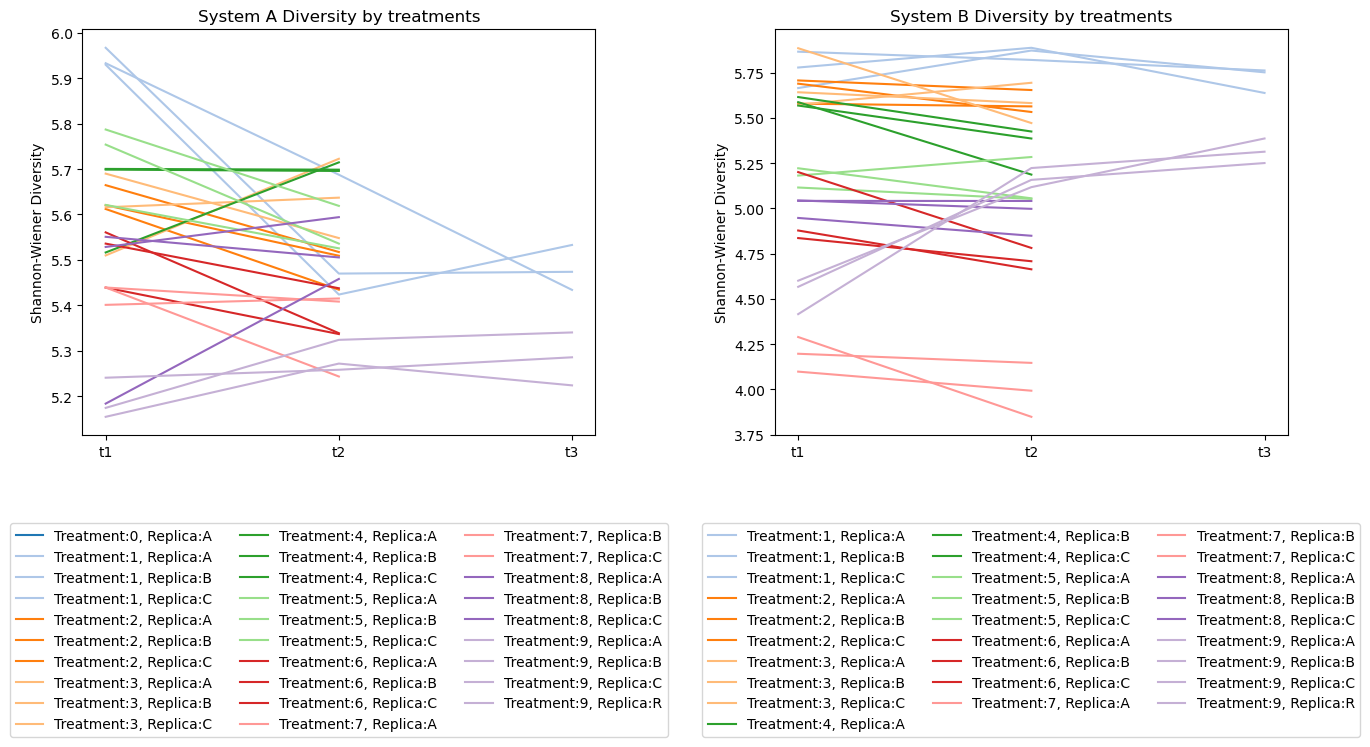

In [21]:
# Create a color dictionary based on unique treatment values
unique_treatments = pivot_df['Treatment'].unique()
color_dict = {treatment: plt.cm.tab20(i) for i, treatment in enumerate(unique_treatments)}

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 8))  # 1 row, 2 columns

# System A Plot
ax = axes[0]
for j, row in pivot_df[pivot_df["System"] == "A"].iterrows():
    treatment = row["Treatment"]
    color = color_dict[treatment]
    ax.plot(row[["t1", "t2", "t3"]], label=f'Treatment:{treatment}, Replica:{row["Replica"]}', color=color)
ax.set_title("System A Diversity by treatments")
ax.set_ylabel("Shannon-Wiener Diversity")
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.2))

# System B Plot
ax = axes[1]
for j, row in pivot_df[pivot_df["System"] == "B"].iterrows():
    treatment = row["Treatment"]
    color = color_dict[treatment]
    ax.plot(row[["t1", "t2", "t3"]], label=f'Treatment:{treatment}, Replica:{row["Replica"]}', color=color)
ax.set_title("System B Diversity by treatments")
ax.set_ylabel("Shannon-Wiener Diversity")
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.2))

plt.tight_layout()  # Automatically adjust subplot parameters to give enough space
plt.show()

Do we see any correlation with environmental variables?

In [22]:
#code correlation

# What are the main living organisms that are present? How are they affected by the different treatments?

Again, analyzing by species

In [23]:
by_specie_df = abd_df[abd_df["Taxonomic Rank"] == "S"]
by_specie_df.head()

,Scientific Name,Taxonomic Rank,A0,A1_1A,A1_1B,A1_1C,A1_2A,A1_2B,A1_2C,A1_3A,...,B9_1A,B9_1B,B9_1C,B9_2A,B9_2B,B9_2C,B9_3A,B9_3B,B9_3BR,B9_3C
0,Homo sapiens,S,0.0,0.05,0.05,0.05,0.05,0.07,0.08,0.05,...,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.03,0.03
6,Cicer arietinum,S,0.0,0.01,0.01,0.01,0.01,0.02,0.03,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
8,Glycine max,S,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,Glycine soja,S,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,Medicago truncatula,S,0.0,0.01,0.01,0.01,0.01,0.02,0.02,0.01,...,0.01,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.01


Normalize the values, over their collective % sum

In [24]:
by_specie_df = abd_df[abd_df["Taxonomic Rank"] == "S"].copy()
for c in by_specie_df.columns[2:]:
    by_specie_df[c] = by_specie_df[c]/by_specie_df[c].sum()*100
by_specie_df.head()

,Scientific Name,Taxonomic Rank,A0,A1_1A,A1_1B,A1_1C,A1_2A,A1_2B,A1_2C,A1_3A,...,B9_1A,B9_1B,B9_1C,B9_2A,B9_2B,B9_2C,B9_3A,B9_3B,B9_3BR,B9_3C
0,Homo sapiens,S,0.0,0.262329,0.318878,0.286041,0.327225,0.447284,0.518135,0.831947,...,0.622084,0.624025,0.598802,0.632911,0.626305,0.641026,0.457666,0.442478,0.649351,0.649351
6,Cicer arietinum,S,0.0,0.052466,0.063776,0.057208,0.065445,0.127796,0.194301,0.166389,...,0.155521,0.156006,0.149701,0.210970,0.208768,0.213675,0.228833,0.221239,0.216450,0.216450
8,Glycine max,S,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Glycine soja,S,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.064767,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,Medicago truncatula,S,0.0,0.052466,0.063776,0.057208,0.065445,0.127796,0.129534,0.166389,...,0.155521,0.156006,0.149701,0.000000,0.208768,0.213675,0.000000,0.000000,0.000000,0.216450


To find the most present species in each sample we will grab the first quartile on each

In [25]:
thr = 0.95
thresholds = by_specie_df.quantile(q=[thr], axis=0, numeric_only=True).to_dict()
thresholds

{'A0': {0.95: 0.061236987140232714},
 'A1_1A': {0.95: 0.052465897166841545},
 'A1_1B': {0.95: 0.06377551020408163},
 'A1_1C': {0.95: 0.057208237986270026},
 'A1_2A': {0.95: 0.06544502617801047},
 'A1_2B': {0.95: 0.06389776357827476},
 'A1_2C': {0.95: 0.06476683937823834},
 'A1_3A': {0.95: 0.0},
 'A1_3B': {0.95: 0.0},
 'A1_3C': {0.95: 0.0},
 'A2_1A': {0.95: 0.0},
 'A2_1B': {0.95: 0.0},
 'A2_1C': {0.95: 0.0},
 'A2_2A': {0.95: 0.0},
 'A2_2B': {0.95: 0.0},
 'A2_2C': {0.95: 0.0},
 'A3_1A': {0.95: 0.0},
 'A3_1B': {0.95: 0.1408450704225352},
 'A3_1C': {0.95: 0.0},
 'A3_2A': {0.95: 0.1400560224089636},
 'A3_2B': {0.95: 0.0},
 'A3_2C': {0.95: 0.0},
 'A4_1A': {0.95: 0.1422475106685633},
 'A4_1B': {0.95: 0.0},
 'A4_1C': {0.95: 0.10744985673352435},
 'A4_2A': {0.95: 0.13368983957219252},
 'A4_2B': {0.95: 0.1443001443001443},
 'A4_2C': {0.95: 0.12468827930174566},
 'A5_1A': {0.95: 0.0},
 'A5_1B': {0.95: 0.12150668286755771},
 'A5_1C': {0.95: 0.13280212483399736},
 'A5_2A': {0.95: 0.0},
 'A5_2B': {0

With this we see that the data is very very sparse. We have many organisms that contribute a small percent.Note that the above values are in %

We'll do another approach. We'll compute this dataset for all species and then look at each of them and find if they have any trends.
 

In [37]:
#Original single threaded process
"""
from tqdm import tqdm

lenght = len(by_specie_df)
quarto = int(lenght/8)

chunks = []
for sep in range(0,8):
    df_rows = []
    indexed = []
    for i,row in tqdm(by_specie_df[quarto:quarto*sep+1].iterrows(),total=len(by_specie_df)):
        for col in by_specie_df.columns[3:]: #avoid also A0
            t = col[3]
            specie = row["Scientific Name"]
            id = specie + "_" + col[0]+col[1]+"_"+col[4:]

            if id not in indexed: #new row
                data_dict = {
                    "id": id,
                    "Specie": specie,
                    "System": col[0],
                    "Treatment": col[1],
                    "Replica": col[4:]
                }
                data_dict["t" + t] = row[col]
                df_rows.append(data_dict)
                indexed.append(id)

            else: #add
                idx = indexed.index(id)
                df_rows[idx]["t" + t] = row[col]
    chunks.append(df_rows)
"""

'\nfrom tqdm import tqdm\n\nlenght = len(by_specie_df)\nquarto = int(lenght/8)\n\nchunks = []\nfor sep in range(0,8):\n    df_rows = []\n    indexed = []\n    for i,row in tqdm(by_specie_df[quarto:quarto*sep+1].iterrows(),total=len(by_specie_df)):\n        for col in by_specie_df.columns[3:]: #avoid also A0\n            t = col[3]\n            specie = row["Scientific Name"]\n            id = specie + "_" + col[0]+col[1]+"_"+col[4:]\n\n            if id not in indexed: #new row\n                data_dict = {\n                    "id": id,\n                    "Specie": specie,\n                    "System": col[0],\n                    "Treatment": col[1],\n                    "Replica": col[4:]\n                }\n                data_dict["t" + t] = row[col]\n                df_rows.append(data_dict)\n                indexed.append(id)\n\n            else: #add\n                idx = indexed.index(id)\n                df_rows[idx]["t" + t] = row[col]\n    chunks.append(df_rows)\n'

Parallelize the process to make it faster

In [33]:
from tqdm import tqdm
import multiprocessing
from utils import process_chunk

# Set the number of processes to use (you can adjust this)
num_processes = 8

# Divide the data into chunks
length = len(by_specie_df)
quarto = int(length / num_processes)
chunks = [by_specie_df[quarto * i: quarto * (i + 1)] for i in range(num_processes)]

# Create a pool of worker processes
pool = multiprocessing.Pool(num_processes)

# Process the data in parallel using the pool of worker processes
results = pool.map(process_chunk, chunks)

# Close the pool of worker processes
pool.close()
pool.join()

# Combine the results from all the processes
combined_data = []
for result in results:
    combined_data.extend(result)

In [34]:
species_df = pd.DataFrame(combined_data)

In [41]:
species_df.to_csv("sample_by_specie_timewise.csv",index=False)

In [42]:
species_df = pd.read_csv("sample_by_specie_timewise.csv")
species_df

,id,Specie,System,Treatment,Replica,t1,t2,t3
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,NaN
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,NaN
...,...,...,...,...,...,...,...,...
684987,Heterocapsa circularisquama DNA virus 01_B8_C,Heterocapsa circularisquama DNA virus 01,B,8,C,NaN,NaN,NaN
684988,Heterocapsa circularisquama DNA virus 01_B9_A,Heterocapsa circularisquama DNA virus 01,B,9,A,NaN,NaN,NaN
684989,Heterocapsa circularisquama DNA virus 01_B9_B,Heterocapsa circularisquama DNA virus 01,B,9,B,NaN,NaN,NaN
684990,Heterocapsa circularisquama DNA virus 01_B9_C,Heterocapsa circularisquama DNA virus 01,B,9,C,NaN,NaN,NaN


Looking at more present species by SYSTEM for all timestamps: (by mean value)

In [39]:
thr = 0.4
mean_vals = species_df[species_df["System"] == "A"][["t1","t2","t3"]].mean(axis=1).to_numpy()
idxs = np.where(mean_vals > thr)
species_df.iloc[idxs]

,id,Specie,System,Treatment,Replica,t1,t2,t3
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,NaN
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,NaN
...,...,...,...,...,...,...,...,...
312671,Limnohabitans sp. 63ED37-2_A8_C,Limnohabitans sp. 63ED37-2,A,8,C,0.000000,0.000000,NaN
312672,Limnohabitans sp. 63ED37-2_A9_A,Limnohabitans sp. 63ED37-2,A,9,A,0.000000,0.000000,0.000000
312673,Limnohabitans sp. 63ED37-2_A9_B,Limnohabitans sp. 63ED37-2,A,9,B,0.000000,0.000000,0.000000
312674,Limnohabitans sp. 63ED37-2_A9_C,Limnohabitans sp. 63ED37-2,A,9,C,0.000000,0.000000,0.000000


In [40]:
thr = 0.1
mean_vals = species_df[species_df["System"] == "B"][["t1","t2","t3"]].mean(axis=1).to_numpy()
idxs = np.where(mean_vals > thr)
species_df.iloc[idxs]

,id,Specie,System,Treatment,Replica,t1,t2,t3
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,NaN
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,NaN
...,...,...,...,...,...,...,...,...
314266,Lizard atadenovirus A_B8_B,Lizard atadenovirus A,B,8,B,NaN,NaN,NaN
314267,Lizard atadenovirus A_B8_C,Lizard atadenovirus A,B,8,C,NaN,NaN,NaN
314268,Lizard atadenovirus A_B9_A,Lizard atadenovirus A,B,9,A,NaN,NaN,NaN
314270,Lizard atadenovirus A_B9_C,Lizard atadenovirus A,B,9,C,NaN,NaN,NaN


In [ ]:
species_df

,Specie,System,Treatment,Replica,t1,t2,t3
0,Homo sapiens,A,1,A,0.598802,0.641026,0.649351
1,Cicer arietinum,A,1,A,0.149701,0.213675,0.216450
2,Glycine max,A,1,A,0.000000,0.000000,0.000000
3,Glycine soja,A,1,A,0.000000,0.000000,0.000000
4,Medicago truncatula,A,1,A,0.149701,0.213675,0.216450
...,...,...,...,...,...,...,...
12233,Lake Sarah-associated circular virus-16,A,1,A,NaN,NaN,NaN
12234,Lake Sarah-associated circular virus-38,A,1,A,NaN,NaN,NaN
12235,Leptopilina boulardi filamentous virus,A,1,A,NaN,NaN,NaN
12236,Mollivirus sibericum,A,1,A,0.000000,NaN,NaN


Looking at more present species by TREATMENT for all timestamps: (by mean value)

In [ ]:
species_df[species_df["System"] == "B"]

,Specie,System,Treatment,Replica,t1,t2,t3


In [ ]:
thr = 0.001
mean_vals = species_df[species_df["Treatment"] == "A"][["t1","t2","t3"]].mean(axis=1).to_numpy()
idxs = np.where(mean_vals > thr)
species_df.iloc[idxs]

,Specie,System,Treatment,Replica,t1,t2,t3


- Which are the most common species by system?
- Which are the most common by combination of system and treatment?

Used chatGpt to help parallelize the code and make it faster